## Face Recognition using Eigenfaces

This notebook contains an implementation of a face recognition system using Eigenfaces. This approach is computationally less expensive and easy to implement, than other methods due to the reduction of the dimensions of the data through Principal Component Analysis.

Sirovich and Kirby showed that principal component analysis could be used on a collection of face images to form a set of basis features. These basis images, known as eigenfaces, could be linearly combined to reconstruct images in the original training set. The principal components are computed by eigen decomposition of the data covariance matrix thus transforming a large set of variables into a smaller one that still contains most of the information of the large set.

In [ ]:
# importing the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as expr
import glob
import re
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Training

Firstly, defining a function that converts the images to vectors and returns them with their associated labels.

In [ ]:
def loadImages(path, set_number):

  set_folder = path+"/"+set_number
  persons = glob.glob(set_folder+"/*.png")
  faces = []
  labels = []
  
  for person in persons:
    face = plt.imread(person)
    who_am_i = int(re.split("_", (re.split(set_folder+"/person", person))[1])[0])
    labels.append(who_am_i)
    faces.append(face.flatten())
  
  return np.stack(faces, axis=0), labels

The following function is used to normalise the data. In initial tests without preprocessing the accuracy was too low in comparison, which is reasonable since Principal Components are the ones with the highest variance and removing the "mean face" and dividing by the standard deciation is important before the creation of the Eigenfaces.

In [ ]:
def normalise(faces):

  # mean face
  average_face = np.mean(faces, axis=0)

  # standard deviation
  dev = np.std(faces, axis=0)

  # normalise and save the vectors
  X = np.ndarray(shape=faces.shape)
  for j in range((faces.shape[0])):
    for i in range((faces.shape[1])):
      X[j][i] = (faces[j][i] - average_face.data[i])/dev.data[i]

  return X

For training I used sklearn's PCA algorithm of the decomposition module. For classification I used the k-nearest neighbor classifier with one number of neighbour. I'm training using the train set with 9 and 30 number of components and then classifying for the five sets of data.


Ακρίβεια Ταξινόμησης και Confusion Matrixes για d = 9 



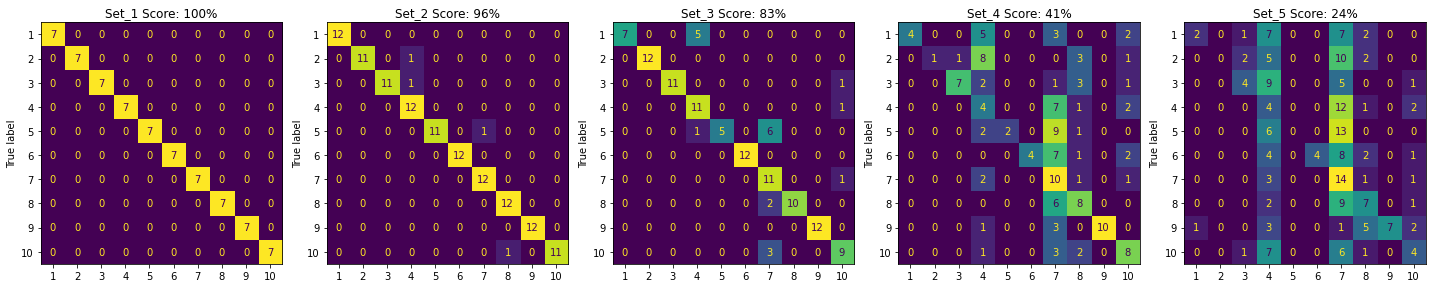


Ακρίβεια Ταξινόμησης και Confusion Matrixes για d = 30 



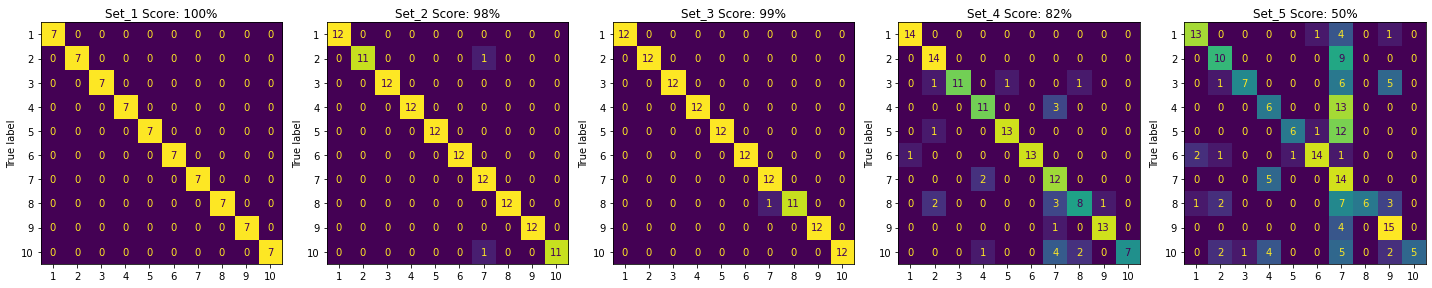

In [28]:
# load the training set
X_set1, y_set1 = loadImages("/content/gdrive/MyDrive/ColabNotebooks/faces", "Set_1")

# average face used later for reconstruction
average_face = np.mean(X_set1, axis=0)

# normalisation of the training set
X_train_set = normalise(X_set1)

# training for 9 and 30 dimensions
dimensions=[9,30]
accura = []
for d in dimensions:

  print("\nΑκρίβεια Ταξινόμησης και Confusion Matrixes για d =", d ,"\n" )

  # PCA training
  pca = PCA(n_components=d, whiten=True).fit(X_train_set)
  X_train_components = pca.transform(X_train_set)

  # classification of train set
  classifier = KNeighborsClassifier(n_neighbors=1)
  classifier.fit(X_train_components, y_set1)

  f, axes = plt.subplots(1, 5, figsize=(20, 5))
  for i in range (1,6):

    # for each set of images
    X_set, y_set = loadImages("/content/gdrive/MyDrive/ColabNotebooks/faces", "Set_"+str(i))

    # normalisation and transform
    X_test = pca.transform(normalise(X_set))

    # face prediction
    y_pred = classifier.predict(X_test)

    # accuracy
    accura.append(int(accuracy_score(y_set, y_pred)*100))

    # printing score and confusion matrices
    names =[1,2,3,4,5,6,7,8,9,10]
    cfmatr = confusion_matrix(y_set, y_pred)
    cmd = ConfusionMatrixDisplay(cfmatr, display_labels=names)
    cmd.plot(ax=axes[i-1])
    cmd.ax_.set_title("Set_"+str(i)+ " Score: "+str(int(accuracy_score(y_set, y_pred)*100))+"%")
    cmd.im_.colorbar.remove()
    cmd.ax_.set_xlabel('')

  # plotting confusion matrices
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.tight_layout()
  plt.show()

As expected set 1 that was used for training has a perfect accuracy score. With 9 principal components the accuracy of the seond and third set is decent (96% and 83% accordingly), with the last two sets having below 50% accuracy. Increasing to 30 principal components we see an increase in accuracy with the second and third sets close to 100%. On the fourth set the accuracy is also pretty decent at 84%, while on the last set it increases to 50%. (Note that the fifth set's images are very dark).

Increasing the dimension from 9 to 30 increases the accuracy significantly and the method is generalising better in the rest of the sets. The first principal components has the largest variance and each of the subsequent ones has the largest remaining with the restriction that they're orthogonal to each other. This means that by adding components we can extract more and different features from the data.

### Representation of the 9 principal Eigenvectors

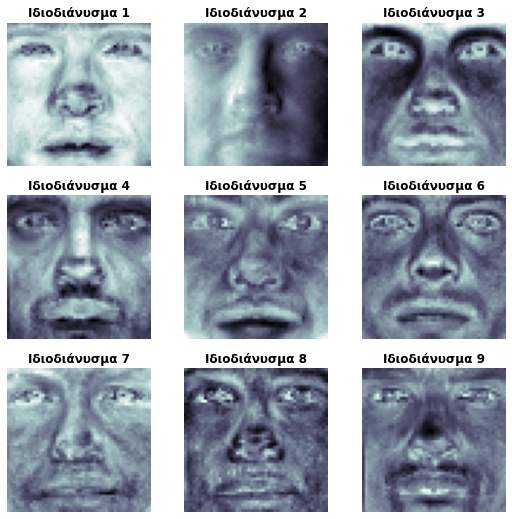

In [26]:
plt.figure(figsize=(9, 9))
for i in range(1,10):
  plt.subplot(3, 3, i)
  plt.axis('off')
  plt.title('Ιδιοδιάνυσμα %d' %i, fontweight ="bold")
  plt.imshow(pca.components_[i-1].reshape(50, 50), cmap='bone')

The bone colour map was selected for plotting the eigenvectors so that the differences are more pronounced. The Eigenfaces are sorted in descending order with the ones with the higher eigenvalues appearing first.

### Face Reconstruction

For the face reconstruction I'll be selecting a random image from each set then using the dot product of the principal components and add the average face that was removed during preprocessing. The reconstruction will be performed for both eigenspaces.

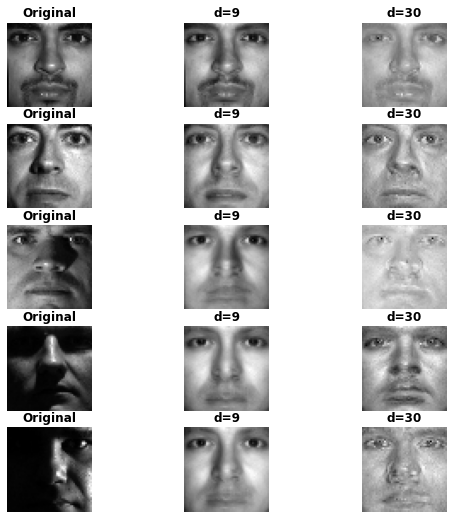

In [29]:
image_matrix = np.zeros((15, 2500))
j=0
for i in range (1,6):

  # get the set
  X_s, y_s = loadImages("/content/gdrive/MyDrive/ColabNotebooks/faces", "Set_"+str(i))

  pick_a_photo =  np.random.randint(len(y_s)) 

  # initialise the average face
  image_matrix[j]= X_s[pick_a_photo]
  j+=1
  
  # for d=9 and 30
  for d in dimensions:

    # normalisation and transform
    Xh = np.dot(pca.transform(normalise(X_s))[:,:d], pca.components_[:d,:])
    image_matrix[j] = Xh[pick_a_photo]+average_face
    j+=1

# reconstruct them using gray colourmap
plt.figure(figsize=(9, 9))
for i in range(1,16):
  plt.subplot(5, 3, i)
  plt.axis('off')
  if ((i-1)%3)==0:
    plt.title('Original', fontweight ="bold")
  elif ((i-1)%3)==1:
    plt.title('d=9', fontweight ="bold")
  else:
    plt.title('d=30', fontweight ="bold")
  plt.imshow((image_matrix[i-1]).reshape(50, 50), cmap='gray')

The reconstruction from the first set is the closest to the actual one. The second set is also close, but the rest of the sets are more close to the average face rather than the one they're supposed to look like. With 30 dimensions the images look a bit worse, but that is actually the increase in features that causes them to carry more information and thus have more sharpness. The two last sets look really bad, but that is also because of the bad lighting conditions of the faces that have to be reconstructed and that are in complete contrast to the well lit photos of the first set used for training.

### Representation of SVD's 9 Singular Vectors

Initially, performing singular value decomposition and comparing to the singular vectors of the PCA method. 

Eigen vectors


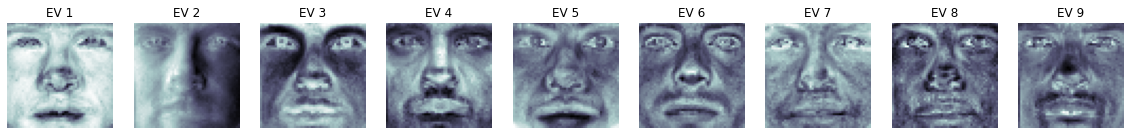


Singular vectors


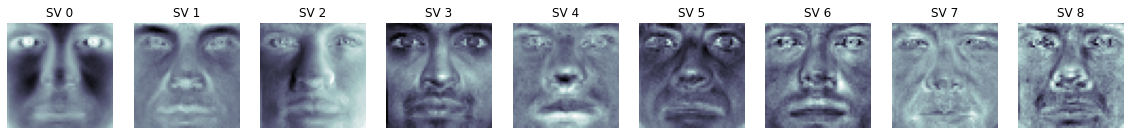

In [41]:
# singular value decomposition of training set
U, s, VT = np.linalg.svd(X_set1,full_matrices=0)

# eigen vectors plotting
print("Eigen vectors")
plt.figure(figsize=(20, 20))
for i in range(1,10):
  plt.subplot(1, 9, i)
  plt.axis('off')
  plt.title('EV %d' %i, fontweight ="light")
  plt.imshow(pca.components_[i-1].reshape(50, 50), cmap='bone')
plt.show()

# singular vectors plotting
print("\nSingular vectors")
plt.figure(figsize=(20, 20))
for i in range(1,10):
  plt.subplot(1, 9, i)
  plt.axis('off')
  plt.title('SV %d' %(i-1), fontweight ="light")
  plt.imshow(VT[i-1,:].reshape(50, 50), cmap='bone')
plt.show()

The singular vectors look close when it comes to the characteristics of the faces, but slightly different when it comes to the darkness. The SVD is applied to the matrix of the first dataset, while PCA on the covariance matrix, so that the dimensions are reduced. The differences are also because for the PCA method there has been preprocessing that removed the mean and divided by the standard deviations. This makes the eigen vectors not carry lack that extra bit of information that is still present in the singular methods.